# Аналитика для авиакомпании с помощью PySpark

Некая российская авиакомпания, выполняющая внутренние пассажирские перевозки, хочет понять предпочтения пользователей, покупающих билеты на разные направления.

Необходимо изучить спрос пассажиров на рейсы в города, где проходят крупнейшие культурные мероприятия ("фестивали"). Для этого в нашем распоряжении есть БД из пяти связанных между собой таблиц и одной несвязанной. Необходимо сформулировать ряд запросов, импортировать результаты трех запросов в Jupyter Notebook посредством PySpark и произвести анализ. 

Результаты запросов выгружены в .csv. Более подробное описание трех запросов и задач, которые необходимо выполнить с их помощью:

**query_1.csv** — результат первого запроса. В нём содержится такая информация:

- *model* — модель самолета;
- *flights_amount* — количество рейсов для каждой модели самолетов в сентябре 2018 года.

**query_3.csv** — результат третьего запроса. В нём содержится такая информация:

- *city* — город;
- *average_flights* — среднее количество рейсов, прибывающих в город за день в сентябре 2018 года.

 Для этих двух наборов данных нужно проверить типы данных на корректность, вывести топ-10 городов по количеству рейсов, построить графики для моделей самолётов и количества рейсов; городов и количества рейсов; топ-10 городов и количества рейсов; сделать выводы по каждому из графиков.

**query_last.csv** — результат последнего запроса. В нём следующая информация:

- *week_number* — номер недели;
- *ticket_amount* — количество проданных билетов за неделю;
- *festival_week —* проходит ли на этой неделе фестиваль;
- *festival_name —* название фестиваля.

С помощью последнего запроса необходимо проверить гипотезу: «Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».

Пороговое значение *alpha* зададим равным 0.05.

### Запрос 1 (query_1): 

```SQL
SELECT 
aircrafts.model AS model,
COUNT(flights.departure_time) AS flights_amount
FROM
aircrafts
LEFT JOIN flights ON flights.aircraft_code = aircrafts.aircraft_code
WHERE 
(EXTRACT(MONTH FROM flights.departure_time) = 9) AND (EXTRACT(YEAR FROM flights.departure_time)=2018)
GROUP BY
aircrafts.model;
```

### Запрос 3 (query_3): 

```SQL
SELECT
flights_per_day.city AS city,
AVG(flights_per_day.cnt) as average_flights
FROM
(SELECT 
 COUNT(flights.flight_id) as cnt,
 airports.city as city,
 DATE_TRUNC('day', flights.arrival_time) as date
 FROM airports INNER JOIN flights ON airports.airport_code = flights.arrival_airport
 GROUP BY
 city,
 date) AS flights_per_day
 GROUP BY city;
 ```
 
### Финальный запрос (query_last): 

```SQL
SELECT 
	T.week_number,
	T.ticket_amount,
	T.festival_week,
	T.festival_name
FROM 
((SELECT 
 COUNT(ticket_flights.ticket_no) AS ticket_amount,
 EXTRACT(WEEK FROM flights.arrival_time) AS week_number
 FROM
  ticket_flights
 INNER JOIN flights ON flights.flight_id = ticket_flights.flight_id
 WHERE
  arrival_airport IN
  (SELECT
  flights.arrival_airport AS arrival_airport
  FROM airports
  INNER JOIN flights ON airports.airport_code = flights.arrival_airport
  WHERE airports.city IN ('Москва')) AND 
  (flights.arrival_time :: date) BETWEEN '2018-07-23' AND '2018-09-30'
  GROUP BY 
  week_number
 )
 t
LEFT JOIN 
(SELECT 		
		festival_name,	
		EXTRACT (week FROM festivals.festival_date) AS festival_week
	FROM 
		festivals
	WHERE
		festival_city = 'Москва'
	  AND CAST(festivals.festival_date AS date) BETWEEN '2018-07-23' AND '2018-09-30'
) t2 
ON 
	t.week_number = t2.festival_week
) AS T;
```

# 1. Аналитика

Загрузим библиотеки.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
import seaborn as sns

Загрузим файлы.

In [4]:
APP_NAME = "DataFrames"
SPARK_URL = "local[*]"
spark = SparkSession.builder.appName(APP_NAME) \
.config('spark.ui.showConsoleProgress', 'false').getOrCreate()

query_1_df = pd.read_csv('.../query_1.csv')
spark_query_1 = spark.createDataFrame(query_1_df)

In [6]:
query_3_df = pd.read_csv('.../query_3.csv')
spark_query_3 = spark.createDataFrame(query_3_df)

In [7]:
query_last =spark.read.load('.../query_last.csv',format='csv',header='true',inferSchema='true')

Посмотрим на файлы, проверим, подходят ли типы данных.

In [8]:
spark_query_1

DataFrame[model: string, flights_amount: bigint]

In [9]:
spark_query_1.show()

+-------------------+--------------+
|              model|flights_amount|
+-------------------+--------------+
|    Airbus A319-100|           607|
|    Airbus A321-200|           960|
|     Boeing 737-300|           630|
|     Boeing 767-300|           600|
|     Boeing 777-300|           300|
| Bombardier CRJ-200|          4446|
| Cessna 208 Caravan|          4557|
|Sukhoi SuperJet-100|          4185|
+-------------------+--------------+



In [10]:
spark_query_1.describe().show()

+-------+-------------------+------------------+
|summary|              model|    flights_amount|
+-------+-------------------+------------------+
|  count|                  8|                 8|
|   mean|               null|          2035.625|
| stddev|               null|1965.2039470679445|
|    min|    Airbus A319-100|               300|
|    max|Sukhoi SuperJet-100|              4557|
+-------+-------------------+------------------+



Первый запрос представляет собой небольшую таблицу с моделями самолетов и количеством рейсов, осуществленных каждой моделью. Тип данных столбца с рейсами - bigint, целочисленный тип, вполне подходящий для отображения количества рейсов. Пропусков в таблице нет.

In [11]:
spark_query_3

DataFrame[city: string, average_flights: double]

In [12]:
spark_query_3.show()

+-------------+------------------+
|         city|   average_flights|
+-------------+------------------+
|       Абакан| 3.870967741935484|
|      Анадырь|               1.0|
|        Анапа| 2.161290322580645|
|  Архангельск| 5.354838709677419|
|    Астрахань|2.4516129032258065|
|      Барнаул| 2.612903225806452|
|     Белгород|               6.0|
|   Белоярский|               2.0|
| Благовещенск|               1.0|
|       Братск|               1.0|
|       Брянск|              10.0|
|     Бугульма|               3.0|
|  Владивосток|               3.0|
|  Владикавказ|               2.0|
|    Волгоград| 5.129032258064516|
|      Воркута| 4.580645161290322|
|      Воронеж|               2.0|
|    Геленджик| 2.590909090909091|
|Горно-Алтайск|1.3870967741935485|
|      Грозный| 1.129032258064516|
+-------------+------------------+
only showing top 20 rows



In [13]:
spark_query_3.count()

101

In [14]:
spark_query_3.describe().show()

+-------+---------+------------------+
|summary|     city|   average_flights|
+-------+---------+------------------+
|  count|      101|               101|
|   mean|     null| 5.494189113891766|
| stddev|     null|13.119790408521778|
|    min|   Абакан|               1.0|
|    max|Ярославль|129.77419354838707|
+-------+---------+------------------+



Запрос 3 представляет собой таблицу из 101 объекта - списком городов и средним количеством рейсов, прибывающих в город в указанный период. Тип данных double подходит для отображения дробных чисел. Пропусков в таблице нет. 

Выведем 10 городов с максимальным значением среднего количества прибывающих рейсов. 

In [15]:
spark_query_3.sort('average_flights', ascending = False).show(10)

+---------------+------------------+
|           city|   average_flights|
+---------------+------------------+
|         Москва|129.77419354838707|
|Санкт-Петербург|31.161290322580648|
|    Новосибирск| 17.32258064516129|
|     Красноярск|11.580645161290322|
|   Екатеринбург| 11.32258064516129|
| Ростов-на-Дону|10.193548387096774|
|          Пермь|10.129032258064516|
|         Брянск|              10.0|
|           Сочи| 9.612903225806452|
|      Ульяновск| 9.580645161290322|
+---------------+------------------+
only showing top 10 rows



Более подробный анализ мы проведедем вместе с визуализацией данных, хотя некоторые очевидные выводы нетрудно сделать и сейчас.

### Графики

Визуализируем данные 1 и 3 запросов. 

Построим графики количество рейсов в разбивке по моделям самолетов и их долевое соотношение.

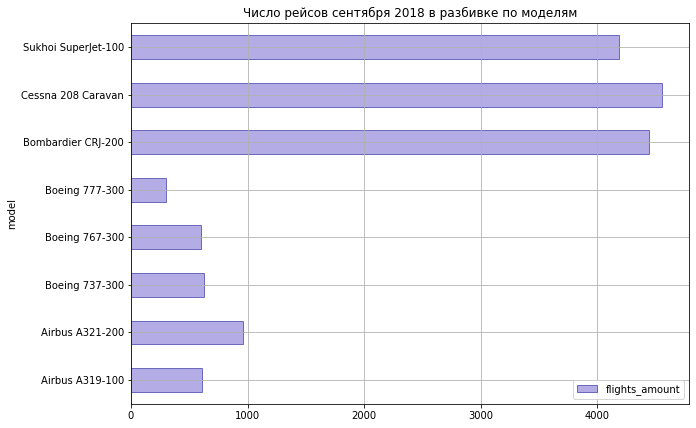

In [16]:
query_1_df.plot(y = 'flights_amount', x = 'model', kind = 'barh', 
                color = 'slateblue', edgecolor = 'darkblue', alpha = 0.5, 
                grid = True, figsize = (10,7), title = 'Число рейсов сентября 2018 в разбивке по моделям')



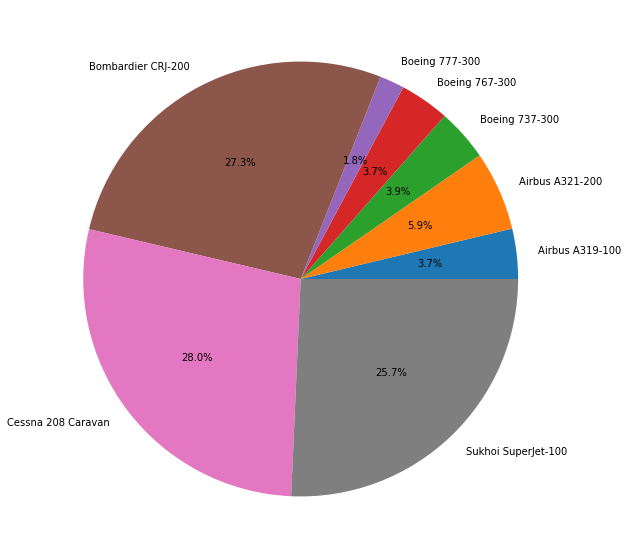

In [17]:
plt.figure(figsize=(10,10))
plt.pie(query_1_df.flights_amount, labels = query_1_df.model, autopct = '%1.1f%%') 
plt.show()

Можно заметить, что по количеству рейсов в сентябре 2018 года с большим отрывом лидируют три модели: Bombardier CRj-200, Cessna 208 Caravan и Сухой Superjet-100. Вместе они заняли более трех четвертей пассажирских авиаперевозок в сентрябре 2018 года. 

Если говорить о городах, то большинство городов принимало за сентябрь в среднем менее 5 рейсов в день. Тем не менее, есть точка, отстоящая от основной группы показаний чрезвычайно далеко. Это Москва (что станет видно на другом графике).

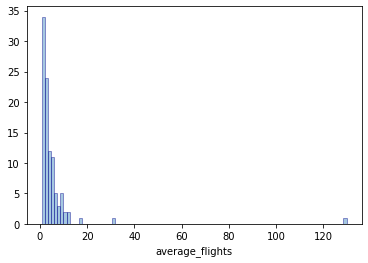

In [18]:
sns.distplot(query_3_df.average_flights, kde = False,  bins=100,hist_kws={'edgecolor':'darkblue'})

Так же можно заметить еще два показания, которые отстоят от общей группы. Как мы впоследствии увидим, это Санкт-Петербург и Новосибирск.  

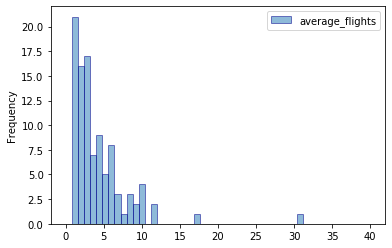

In [19]:
query_3_df.plot(y = 'average_flights', kind = 'hist',
                edgecolor='darkblue', alpha = 0.5, 
                bins = 50, range = [0,40])

In [20]:
top10_cities_df = query_3_df.sort_values(by= 'average_flights', ascending = False).head(10)

Построив график по первой десятке городов, мы можем заметить, насколько первая тройка городов отличается от прочих по среднему количеству принимаемых рейсов в день, и на сколько Москва отличается по пассажиропотоку от остальных городов. 

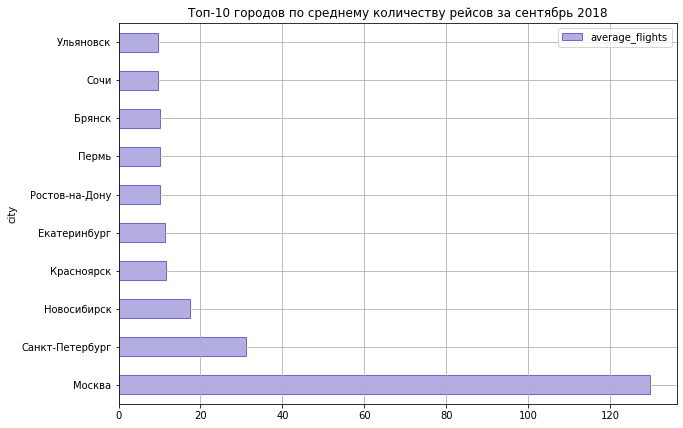

In [21]:
top10_cities_df.plot(y = 'average_flights', x = 'city', kind = 'barh', 
                color = 'slateblue', edgecolor = 'darkblue', alpha = 0.5, 
                grid = True, figsize = (10,7), title = 'Топ-10 городов по среднему количеству рейсов за сентябрь 2018')


На первом месте с огромным отрывом от остальных Москва, за ней, тоже со значительным отрывом от третьего места (почти в два раза) - Санкт-Петербург, на третьем месте Новосибирск. Разрыв между остальными городами по значению среднего количества рейсов не такой большой. 

## Вывод

Окончательный вывод о том, влияет ли модель самолета на спрос на билеты на основании имеющихся данных сложно сделать. У пассажиров может и не быть выбора, на каком самолете лететь. В отсутствие других факторов вывод о том, влияет ли модель самолета на пассажирские предпочтения сделать невозможно. Тем не менее, можно утверждать, что в сентябре 2018 года более 75% рейсов выполнили самолеты трех моделей: Bombardier CRj-200, Cessna 208 Caravan и Сухой Superjet-100.

Как и в случае с моделями самолетов, сложно сделать какие-то весомые выводы на основании этих данных. Большой пассажиропоток в Москве может быть обусловлен разными факторами, не все из которых свидетельствуют о спросе со стороны пассажиров на полеты именно в Москву как пункт назначения. Санкт-Петербург и Москва - и особенно Москва - являются транспортными хабами для всей России, куда из зарубежных поездок часто прилетают люди, чтобы затем разлететься по своим городам, что отчасти объясняет высокое значение среднего количества принимаемых рейсов в день. 

# 2. Проверка гипотезы

Частично на вопрос о факторах пассажиропотока может помочь ответить последний запрос, в котором указаны даты, фестивали и количество билетов в соответствующие дни.

In [22]:
query_last

DataFrame[week_number: int, ticket_amount: int, festival_week: string, festival_name: string]

In [23]:
query_last.show()

+-----------+-------------+-------------+-------------+
|week_number|ticket_amount|festival_week|festival_name|
+-----------+-------------+-------------+-------------+
|         30|        43568|           30|    Park Live|
|         31|        51034|           31| Пикник Афиши|
|         32|        51675|         NULL|         NULL|
|         33|        51378|         NULL|         NULL|
|         34|        51492|         NULL|         NULL|
|         35|        51360|         NULL|         NULL|
|         36|        51386|           36|      Видфест|
|         37|        51670|         NULL|         NULL|
|         38|        51518|         NULL|         NULL|
|         39|        51623|         NULL|         NULL|
+-----------+-------------+-------------+-------------+



Обратим внимание, что в таблице с последним запросом есть пропущенные значения, а так же на то, что в festival_week тип данных - string. Если название фестиваля для нас не столь важно, как его наличие, то указание на то, проводится фестиваль или нет - важно, мы будем делить таблицу по этому признаку. Значит, надо поменять тип данных в таблице и, для удобства, заменить NULL на 0.

In [24]:
from pyspark.sql.types import IntegerType
query_last = query_last.withColumn("festival_week", query_last["festival_week"].cast(IntegerType()))

In [25]:
query_last

DataFrame[week_number: int, ticket_amount: int, festival_week: int, festival_name: string]

In [26]:
query_last.show()

+-----------+-------------+-------------+-------------+
|week_number|ticket_amount|festival_week|festival_name|
+-----------+-------------+-------------+-------------+
|         30|        43568|           30|    Park Live|
|         31|        51034|           31| Пикник Афиши|
|         32|        51675|         null|         NULL|
|         33|        51378|         null|         NULL|
|         34|        51492|         null|         NULL|
|         35|        51360|         null|         NULL|
|         36|        51386|           36|      Видфест|
|         37|        51670|         null|         NULL|
|         38|        51518|         null|         NULL|
|         39|        51623|         null|         NULL|
+-----------+-------------+-------------+-------------+



In [27]:
query_last = query_last.fillna(0)

In [28]:
query_last.show()

+-----------+-------------+-------------+-------------+
|week_number|ticket_amount|festival_week|festival_name|
+-----------+-------------+-------------+-------------+
|         30|        43568|           30|    Park Live|
|         31|        51034|           31| Пикник Афиши|
|         32|        51675|            0|         NULL|
|         33|        51378|            0|         NULL|
|         34|        51492|            0|         NULL|
|         35|        51360|            0|         NULL|
|         36|        51386|           36|      Видфест|
|         37|        51670|            0|         NULL|
|         38|        51518|            0|         NULL|
|         39|        51623|            0|         NULL|
+-----------+-------------+-------------+-------------+



Теперь мы можем легко отделить недели, в которые были фестивали, от недель, в которых фестивалей не было, высчитать для каждой группы среднее количество билетов и проверить гипотезу. 

In [29]:
query_last.registerTempTable("query_last")

spark.sql('SELECT ticket_amount FROM query_last WHERE festival_week > 0').show()

+-------------+
|ticket_amount|
+-------------+
|        43568|
|        51034|
|        51386|
+-------------+



In [30]:
fest = np.array(spark.sql('SELECT ticket_amount FROM query_last WHERE festival_week > 0').take(10))

In [31]:
fest

array([[43568],
       [51034],
       [51386]])

In [32]:
no_fest = np.array(spark.sql('SELECT ticket_amount FROM query_last WHERE festival_week < 1').take(10))

In [33]:
no_fest

array([[51675],
       [51378],
       [51492],
       [51360],
       [51670],
       [51518],
       [51623]])

In [34]:
fest.mean()

48662.666666666664

In [35]:
no_fest.mean()

51530.857142857145

Средние значения количества спроса на билеты в фестивальные и обычные недели довольно сильно отличаются. Однако есть вероятность, что отличия в средних случайны.

Сформулируем нулевую гипотезу (в виде равенства):
«Средний спрос на билеты во время фестивалей не отличается от среднего спроса на билеты в обычное время».
Альтернативная гипотеза:
«Средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время».

Для проверки гипотезы используем не параметрический U-критерий Манна — Уитни, подходящий для оценки различий между двумя малыми выборками, поскольку в нашем случае выборки действительно малые. Согласно авторитетному источнику (https://ru.wikipedia.org/wiki/U-%D0%BA%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_%D0%9C%D0%B0%D0%BD%D0%BD%D0%B0_%E2%80%94_%D0%A3%D0%B8%D1%82%D0%BD%D0%B8) для применения теста необходимо, чтобы в обеих выборках было не менее 3 объектов (или в одной 2, в другой 5 и более). Этот критерий выполнен. 

In [36]:
from scipy import stats as st

In [37]:
alpha = .05 

results = st.mannwhitneyu(fest, no_fest)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.03412374418900064
Отвергаем нулевую гипотезу


Критерий показал, что различия в средних значениях не случайны. Значит, нулевая гипотеза отвергается. Значит, средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время.

## Вывод

На основе данных было выявлено, что в сентябре 2018 года основную часть рейсов осуществляли самолеты трех моделей: Bombardier CRj-200, Cessna 208 Caravan и Сухой Superjet-100. Сделать какие-то далеко идущие выводы о предпочтениях пассажиров на основе этих данных сложно, поскольку популярность этих моделей можно объяснить разными, в т.ч. не связанными со спросом потребителей причинами.

Аналогично, было выявлено, что в сентябре 2018 года Москва с грандиозным отрывом лидировала по среднему количеству принимаемых рейсов в день. Однако это не окончательный показатель спроса пассажиров на рейсы именно в Москву, поскольку объяснить увеличенный пассажиропоток в Москве можно разными факторами.

В результате проверки статистической гипотезы было выявлено, что средний спрос на билеты во время фестивалей отличается от среднего спроса на билеты в обычное время. Примечательно, что если сравнивать средний спрос на основе имеющихся данных, то среднее количество купленных билетов в фестивальные недели ниже, чем среднее количество купленных билетов в обычное время.